In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Connect to the database file you created
conn = sqlite3.connect("global_energy.db")

In [3]:
# Load the World Bank dataset
df_wb_indicators = pd.read_sql_query("""
SELECT DISTINCT [Series Name] as indicator, *
FROM world_bank
""", conn)

# Check if it loaded correctly
print(df_wb_indicators.head())


                                           indicator      country  \
0  Carbon dioxide (CO2) emissions from Building (...  Afghanistan   
1                              Coal rents (% of GDP)  Afghanistan   
2      Adjusted savings: energy depletion (% of GNI)  Afghanistan   
3   Adjusted savings: energy depletion (current US$)  Afghanistan   
4  Alternative and nuclear energy (% of total ene...  Afghanistan   

  Country Code                                        Series Name  \
0          AFG  Carbon dioxide (CO2) emissions from Building (...   
1          AFG                              Coal rents (% of GDP)   
2          AFG      Adjusted savings: energy depletion (% of GNI)   
3          AFG   Adjusted savings: energy depletion (current US$)   
4          AFG  Alternative and nuclear energy (% of total ene...   

  1960 [YR1960] 1961 [YR1961] 1962 [YR1962] 1963 [YR1963] 1964 [YR1964]  \
0            ..            ..            ..            ..            ..   
1            ..     

In [4]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
print("Tables in the database:", tables)

Tables in the database: ['world_bank', 'iea_balances', 'oecd_greengrowth', 'power_plants', 'country_capacity']


In [5]:
for table in tables:
    df_preview = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5;", conn)
    print(f"\n=== Preview of {table} ===")
    print(df_preview)
    print(df_preview.columns)


=== Preview of world_bank ===
       country Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                         Series Name 1960 [YR1960]  \
0  Carbon dioxide (CO2) emissions from Building (...            ..   
1                              Coal rents (% of GDP)            ..   
2      Adjusted savings: energy depletion (% of GNI)            ..   
3   Adjusted savings: energy depletion (current US$)            ..   
4  Alternative and nuclear energy (% of total ene...            ..   

  1961 [YR1961] 1962 [YR1962] 1963 [YR1963] 1964 [YR1964] 1965 [YR1965]  \
0            ..            ..            ..            ..            ..   
1            ..            ..            ..            ..            ..   
2            ..            ..            ..            ..            ..   
3            ..            ..            ..            ..    

In [6]:
for table in tables:
    row_count = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table};", conn)["count"][0]
    df_sample = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 1;", conn)
    col_count = len(df_sample.columns)
    print(f"Table '{table}' has {row_count} rows and {col_count} columns.")

Table 'world_bank' has 37511 rows and 67 columns.
Table 'iea_balances' has 6832 rows and 59 columns.
Table 'oecd_greengrowth' has 677449 rows and 6 columns.
Table 'power_plants' has 34936 rows and 13 columns.
Table 'country_capacity' has 167 rows and 3 columns.


In [7]:
# Example: Summarize capacity by primary_fuel
query_fuel_capacity = """
SELECT primary_fuel, COUNT(*) as plant_count, SUM(capacity_mw) as total_capacity
FROM power_plants
GROUP BY primary_fuel
ORDER BY total_capacity DESC
;
"""
df_fuel_capacity = pd.read_sql_query(query_fuel_capacity, conn)
print(df_fuel_capacity)

      primary_fuel  plant_count  total_capacity
0             Coal         2330    1.965541e+06
1              Gas         3998    1.493051e+06
2            Hydro         7156    1.053160e+06
3          Nuclear          195    4.079118e+05
4             Wind         5344    2.630537e+05
5              Oil         2320    2.618787e+05
6            Solar        10665    1.883123e+05
7          Biomass         1430    3.428130e+04
8            Waste         1068    1.474871e+04
9       Geothermal          189    1.268775e+04
10    Cogeneration           41    4.048000e+03
11           Other           43    3.612860e+03
12         Petcoke           12    2.424577e+03
13         Storage          135    1.712300e+03
14  Wave and Tidal           10    5.522000e+02


In [8]:
query_countries = """
SELECT country, COUNT(*) AS plant_count
FROM power_plants
GROUP BY country
ORDER BY plant_count DESC
LIMIT 10;
"""
df_top_countries = pd.read_sql_query(query_countries, conn)
print("Countries with the most power plants (top 10):")
print(df_top_countries)

Countries with the most power plants (top 10):
                    country  plant_count
0  United States of America         9833
1                     China         4235
2            United Kingdom         2751
3                    Brazil         2360
4                    France         2155
5                     India         1589
6                   Germany         1309
7                    Canada         1159
8                     Spain          829
9                    Russia          545


In [9]:
pd.read_sql_query("PRAGMA table_info(power_plants);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,country_short,TEXT,0,None,0
1,1,country,TEXT,0,None,0
2,2,name,TEXT,0,None,0
3,3,latitude,REAL,0,None,0
4,4,longitude,REAL,0,None,0
5,5,primary_fuel,TEXT,0,None,0
6,6,capacity_mw,REAL,0,None,0
7,7,commissioning_year,REAL,0,None,0
8,8,generation_gwh_2013,REAL,0,None,0
9,9,generation_gwh_2014,REAL,0,None,0


In [10]:
query_missing_capacity = """
SELECT COUNT(*) as missing_capacity
FROM power_plants
WHERE capacity_mw IS NULL
"""
print(pd.read_sql_query(query_missing_capacity, conn))

   missing_capacity
0                 0


In [11]:
# Create a table for total capacity by iso3
conn.execute("DROP TABLE IF EXISTS country_capacity;")

conn.execute("""
CREATE TABLE country_capacity AS
SELECT Country,
       SUM(CASE WHEN primary_fuel IN ('Solar', 'Wind', 'Hydro', 'Geothermal', 'Biomass') 
                THEN capacity_mw ELSE 0 END) AS total_renewable_capacity,
       SUM(capacity_mw) as total_capacity
FROM power_plants
GROUP BY Country;
""")

print("Created 'country_capacity' table with aggregated sums.")

Created 'country_capacity' table with aggregated sums.


### Bar Chart: PowerPlant Count by Country (Top 10)

/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_19018/4096846934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_countries, x="plant_count", y="country", palette="Blues_r")


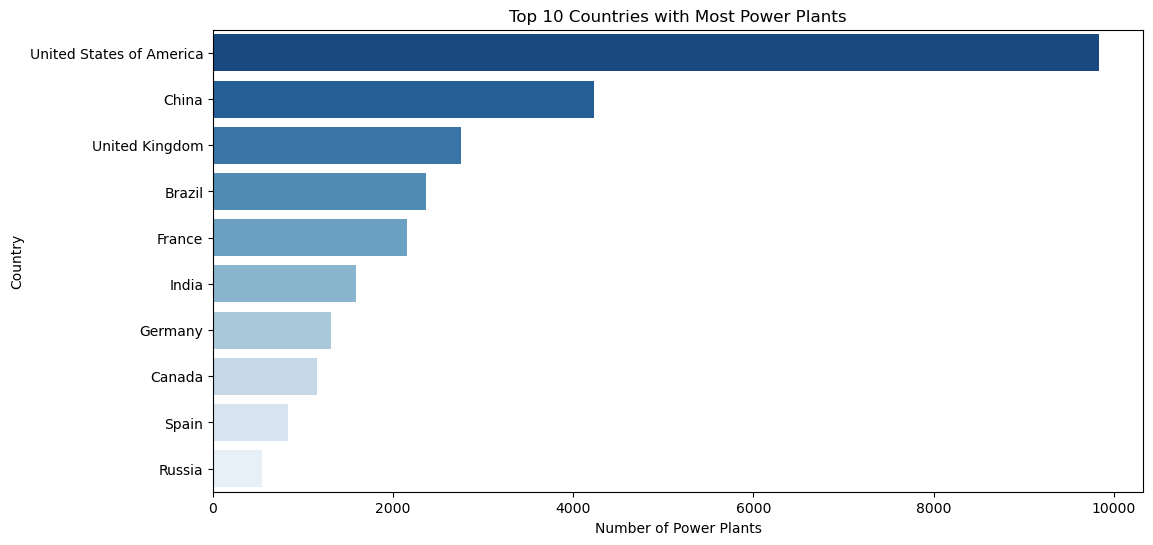

In [12]:

# Plot top 10 countries with most power plants
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_countries, x="plant_count", y="country", palette="Blues_r")
plt.xlabel("Number of Power Plants")
plt.ylabel("Country")
plt.title("Top 10 Countries with Most Power Plants")
plt.show()

### Total Capacity by Energy Source

/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_19018/3879708617.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fuel_capacity, x="total_capacity", y="primary_fuel", palette="coolwarm")


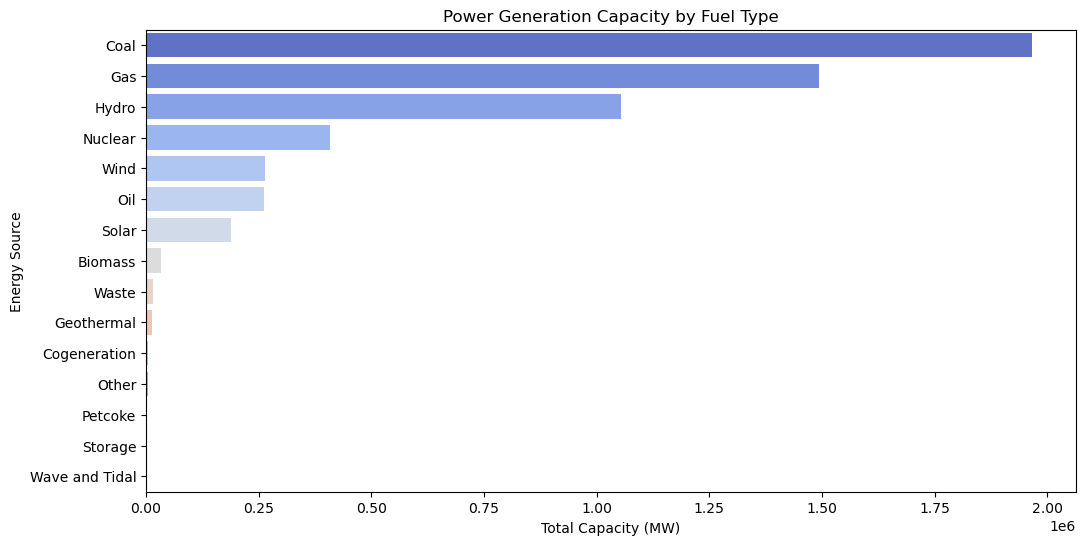

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_fuel_capacity, x="total_capacity", y="primary_fuel", palette="coolwarm")
plt.xlabel("Total Capacity (MW)")
plt.ylabel("Energy Source")
plt.title("Power Generation Capacity by Fuel Type")
plt.show()

### Renewable vs. Non-Renewable Energy Mix

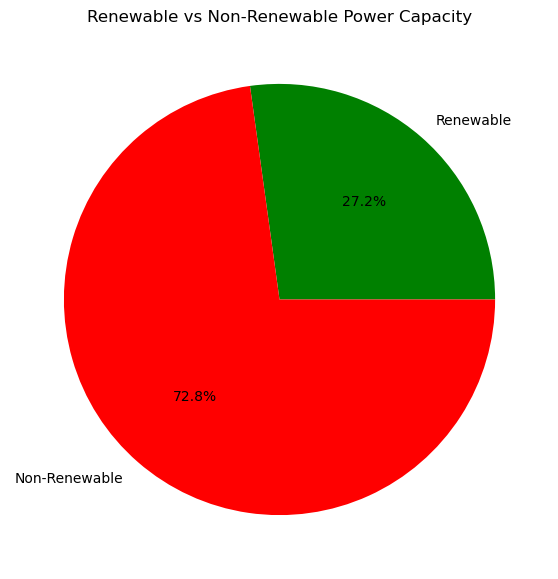

In [14]:
renewable_capacity = df_fuel_capacity[df_fuel_capacity["primary_fuel"].isin(["Solar", "Wind", "Hydro", "Geothermal", "Biomass"])]["total_capacity"].sum()
non_renewable_capacity = df_fuel_capacity["total_capacity"].sum() - renewable_capacity

plt.figure(figsize=(7, 7))
plt.pie([renewable_capacity, non_renewable_capacity], labels=["Renewable", "Non-Renewable"], autopct="%1.1f%%", colors=["green", "red"])
plt.title("Renewable vs Non-Renewable Power Capacity")
plt.show()

In [15]:
# Identify year columns (they contain a 4-digit year with [YRYYYY] format)
year_columns = [col for col in df_wb_indicators.columns if "YR" in col]

# Melt the DataFrame correctly
df_wb_trends = df_wb_indicators.melt(
    id_vars=["indicator", "country"],  # Keep indicator & country
    value_vars=year_columns,           # Only melt year columns
    var_name="year",                    # Rename melted column to 'year'
    value_name="value"                   # Rename value column
)

# Extract only the year number (remove "[YRYYYY]")
df_wb_trends["year"] = df_wb_trends["year"].str.extract(r"(\d{4})").astype(int)

# Convert 'value' to numeric (ignore errors, non-numeric values -> NaN)
df_wb_trends["value"] = pd.to_numeric(df_wb_trends["value"], errors="coerce")

# Fill NaN values with 0
df_wb_trends["value"] = df_wb_trends["value"].fillna(0)

# Drop rows where year is 0 (invalid years)
df_wb_trends = df_wb_trends[df_wb_trends["year"] > 1900]  # Ensures valid years only

# Check the cleaned data
print(df_wb_trends.head())

                                           indicator      country  year  value
0  Carbon dioxide (CO2) emissions from Building (...  Afghanistan  1960    0.0
1                              Coal rents (% of GDP)  Afghanistan  1960    0.0
2      Adjusted savings: energy depletion (% of GNI)  Afghanistan  1960    0.0
3   Adjusted savings: energy depletion (current US$)  Afghanistan  1960    0.0
4  Alternative and nuclear energy (% of total ene...  Afghanistan  1960    0.0


In [16]:
# Load the World Bank dataset
df_wb_indicators = pd.read_sql_query("""
SELECT DISTINCT [Series Name] as indicator
FROM world_bank
""", conn)
pd.set_option('display.max_rows', None)  # Remove row display limit
print(df_wb_indicators)
pd.reset_option('display.max_rows')      # Reset to default after



                                             indicator
0    Carbon dioxide (CO2) emissions from Building (...
1                                Coal rents (% of GDP)
2        Adjusted savings: energy depletion (% of GNI)
3     Adjusted savings: energy depletion (current US$)
4    Alternative and nuclear energy (% of total ene...
5    Agriculture, forestry, and fishing, value adde...
6    Adjusted net savings, excluding particulate em...
7    Adjusted net savings, excluding particulate em...
8    Adjusted net savings, including particulate em...
9    Adjusted net savings, including particulate em...
10   Adjusted savings: particulate emission damage ...
11   Adjusted savings: particulate emission damage ...
12                              Broad money (% of GDP)
13   Carbon dioxide (CO2) emissions from Fugitive E...
14   Carbon dioxide (CO2) emissions from Industrial...
15   Carbon dioxide (CO2) emissions from Power Indu...
16   Carbon dioxide (CO2) emissions from Transport ...
17   Combu

In [17]:
important_indicators = [
    "Carbon dioxide (CO2) emissions (kt)",
    "Energy use (kg of oil equivalent per capita)",
    "GDP (current US$)",
    "Electric power consumption (kWh per capita)",
    "Population, total"
]

In [18]:
query_top_countries = """
SELECT country
FROM power_plants
GROUP BY country
ORDER BY COUNT(*) DESC
LIMIT 10;
"""

df_top_countries = pd.read_sql_query(query_top_countries, conn)
top_10_countries = df_top_countries["country"].tolist()
print("Top 10 countries by plant count:", top_10_countries)

Top 10 countries by plant count: ['United States of America', 'China', 'United Kingdom', 'Brazil', 'France', 'India', 'Germany', 'Canada', 'Spain', 'Russia']


In [19]:
# Reminder: df_wb_trends has columns ['indicator', 'country', 'year', 'value']
# We want to filter by (1) 5 indicators, (2) top 10 countries.
df_filtered = df_wb_trends[
    (df_wb_trends["indicator"].isin(important_indicators)) &
    (df_wb_trends["country"].isin(top_10_countries))
].copy()

<Figure size 1200x800 with 0 Axes>

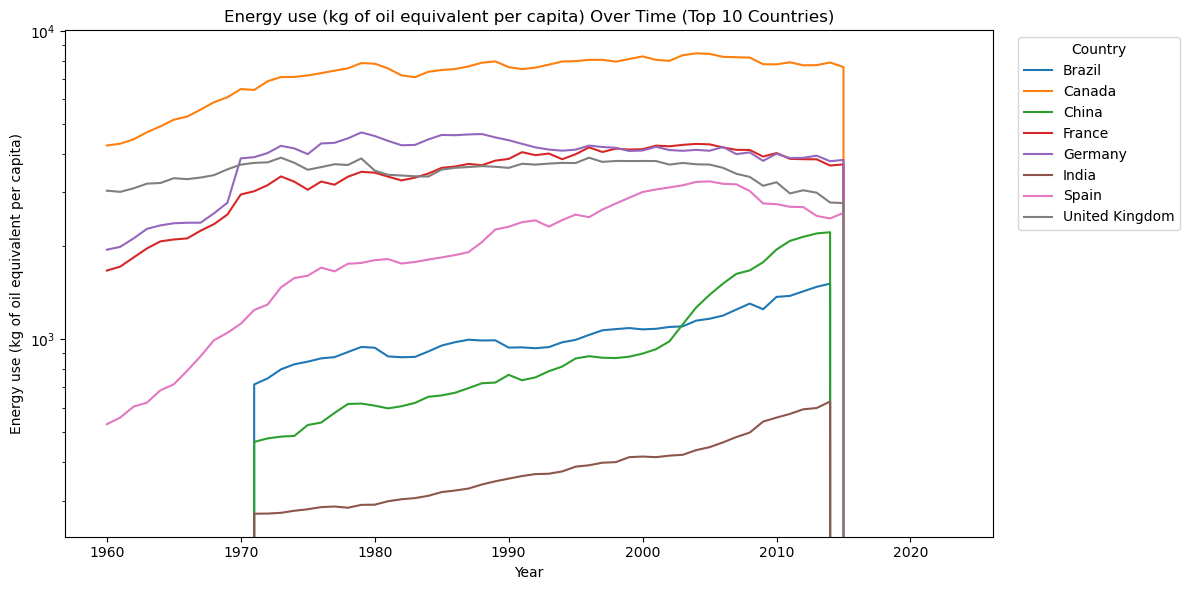

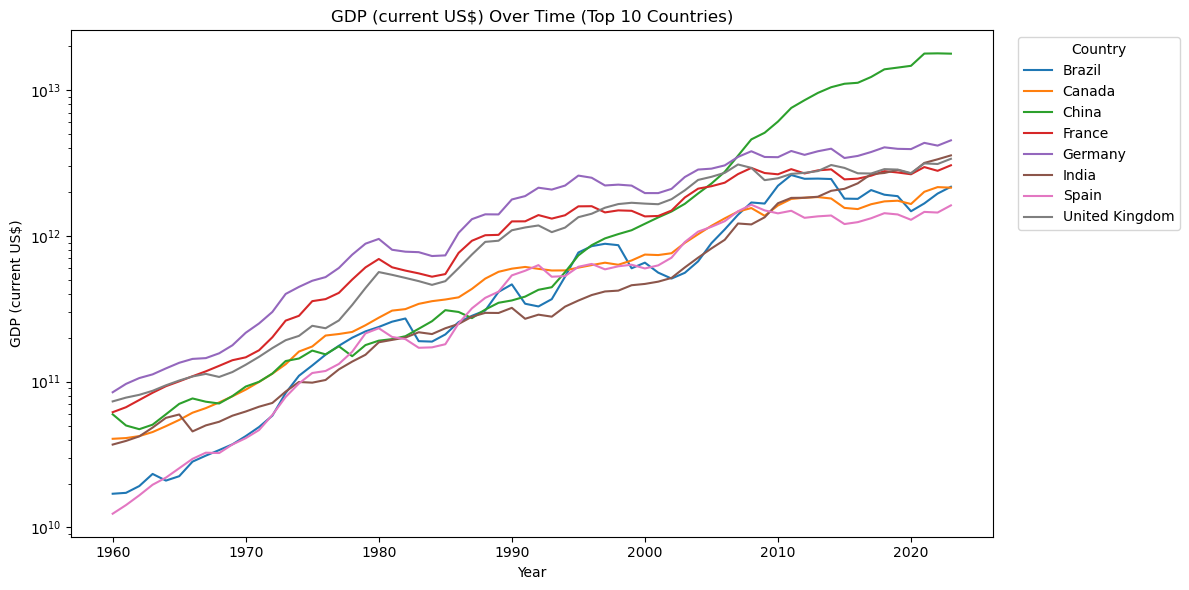

In [24]:


# Ensure years are numeric
df_filtered["year"] = pd.to_numeric(df_filtered["year"], errors="coerce")

# For clarity, set a larger figure size
plt.figure(figsize=(12, 8))

# We'll loop through each indicator to create subplots or separate figures
unique_inds = df_filtered["indicator"].unique()

for ind in unique_inds:
    # Subset data for this specific indicator
    data_ind = df_filtered[df_filtered["indicator"] == ind]
    
    plt.figure(figsize=(12, 6))  # new figure for each indicator
    
    sns.lineplot(
        data=data_ind,
        x="year",
        y="value",
        hue="country",
        #marker="o"
    )
    plt.title(f"{ind} Over Time (Top 10 Countries)")
    plt.xlabel("Year")
    plt.ylabel(ind)
    plt.yscale("log")
    plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()